In [ ]:
%pip install -q git+https://github.com/yfukai/BaSiCPy@autosegment

# Install and import 

In [3]:
import numpy as np
import pandas as pd
from basicpy import BaSiC, datasets, metrics
from itertools import product
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
from os import path
from skimage import filters
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["font.family"] = "sans-serif"
# plt.plot(range(2))

In [4]:
estimated_parameters_df = pd.read_csv(
    "wo_flatfield_estimated_parameters_df_with_autotune.csv", index_col=0
)

In [5]:
estimated_parameters_df.head()

true_flatfield_id  intensity  ave_count  n_images blob_dist_key  rep  \
0                  0         10          0        10        biased    0   
1                  0         10          0        10        biased    0   
2                  0         10          0        10        biased    0   
3                  0         10          0        10        biased    0   
4                  0         10          0        10        biased    0   

   image_index fitting_mode  smoothness_flatfield   time_gpu  time_cpu  \
0            0       ladmap              0.100000  12.112859       NaN   
1            0       ladmap              0.261016   1.139761       NaN   
2            0       ladmap              0.681292   1.060643       NaN   
3            0       ladmap              1.778279   1.070440       NaN   
4            0       ladmap              4.641589   0.868617       NaN   

   deviation   entropy  fourier_L0_norm  autotune_cost  
0   0.024315  1.251328         0.323661    3227.864030  
1   0.018550  1.277066         0.151370    1504.975696  
2   0.008840  1.307435         0.020299     194.296227  
3   0.005247  1.326257         0.000187       1.326257  
4   0.010590  1.335022         0.000000       1.335022

# Calculate deviation

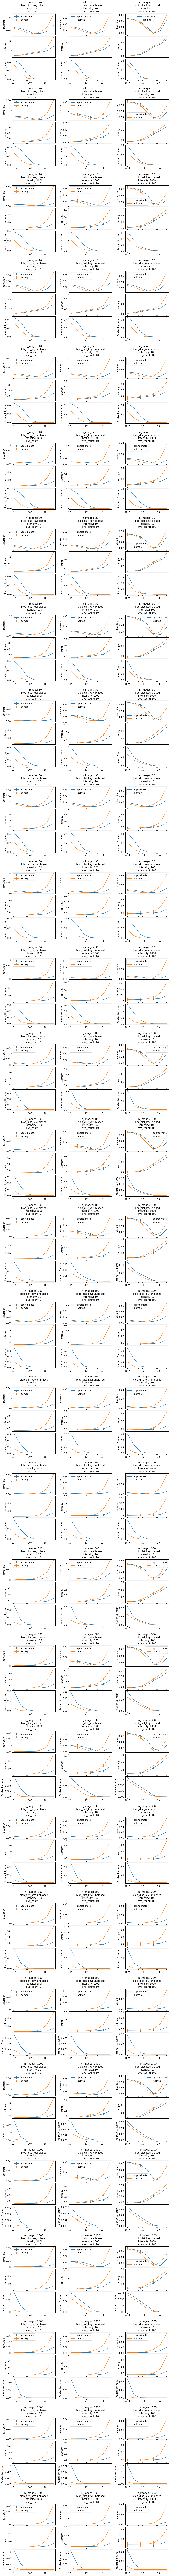

In [6]:
df = estimated_parameters_df[estimated_parameters_df["true_flatfield_id"] == 1]
image_properties = ["n_images", "blob_dist_key", "intensity", "ave_count"]
keys = list(
    set(estimated_parameters_df.keys())
    - {
        "smoothness_flatfield",
        "deviation",
        "true_flatfield_id",
        "image_index",
        "time",
        "rep",
        "entropy",
        "fourier_L0_norm",
        "autotune_cost",
        "time_gpu",
        "time_cpu",
        *image_properties,
    }
)
assert len(keys) == 1

num_imagess = df["ave_count"].unique().tolist()
ncols = len(num_imagess)
grps = list(df.groupby(image_properties))
nrows = (len(grps) - 1) // ncols + 1

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4 * ncols, 6 * nrows),
    # gridspec_kw={"hspace": 1.5, "wspace": 1.0},
    dpi=50,
)
summaried_df_data = []

for ii, (image_property, grp0) in enumerate(df.groupby(image_properties)):
    ax = axes[ii // ncols, ii % ncols]
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="100%", pad=0.1, sharex=ax)
    ax3 = divider.append_axes("bottom", size="100%", pad=0.1, sharex=ax)
    for key, grp in grp0.groupby(keys[0]):
        d = {k: v for k, v in zip(image_properties, image_property)}
        d[keys[0]] = key

        min_deviation_smoothness_flatfield = [
            grp1.loc[grp1["deviation"].idxmin()]["smoothness_flatfield"]
            for _, grp1 in grp.groupby("rep")
        ]
        d["min_deviation_smoothness_flatfield_max"] = np.max(
            min_deviation_smoothness_flatfield
        )
        d["min_deviation_smoothness_flatfield_median"] = np.median(
            min_deviation_smoothness_flatfield
        )
        d["min_deviation_smoothness_flatfield_min"] = np.min(
            min_deviation_smoothness_flatfield
        )
        summaried_df_data.append(d)
        for _ax, name in zip(
            [ax, ax2, ax3], ["deviation", "entropy", "fourier_L0_norm"]
        ):
            vals = (
                grp.groupby("smoothness_flatfield")[name]
                .agg(["mean", "std"])
                .reset_index()
            )

            _ax.errorbar(
                vals["smoothness_flatfield"], vals["mean"], vals["std"], label=key
            )
            _ax.set_ylabel(name)

    ax.set_title(
        "\n".join([f"{k}: {v}" for k, v in zip(image_properties, image_property)]),
    )
    ax.legend()
    ax.set_xlabel("smoothness_flatfield")
    ax.set_xscale("log")

summaried_df = pd.DataFrame.from_records(summaried_df_data)

fig.tight_layout()

In [7]:
summaried_df.head()

n_images blob_dist_key  intensity  ave_count fitting_mode  \
0        10        biased         10          0  approximate   
1        10        biased         10          0       ladmap   
2        10        biased         10         10  approximate   
3        10        biased         10         10       ladmap   
4        10        biased         10        100  approximate   

   min_deviation_smoothness_flatfield_max  \
0                                4.641589   
1                                1.778279   
2                                4.641589   
3                                1.778279   
4                                4.641589   

   min_deviation_smoothness_flatfield_median  \
0                                   4.641589   
1                                   1.778279   
2                                   4.641589   
3                                   1.778279   
4                                   4.641589   

   min_deviation_smoothness_flatfield_min  
0                                4.641589  
1                                1.778279  
2                                4.641589  
3                                1.778279  
4                                4.641589

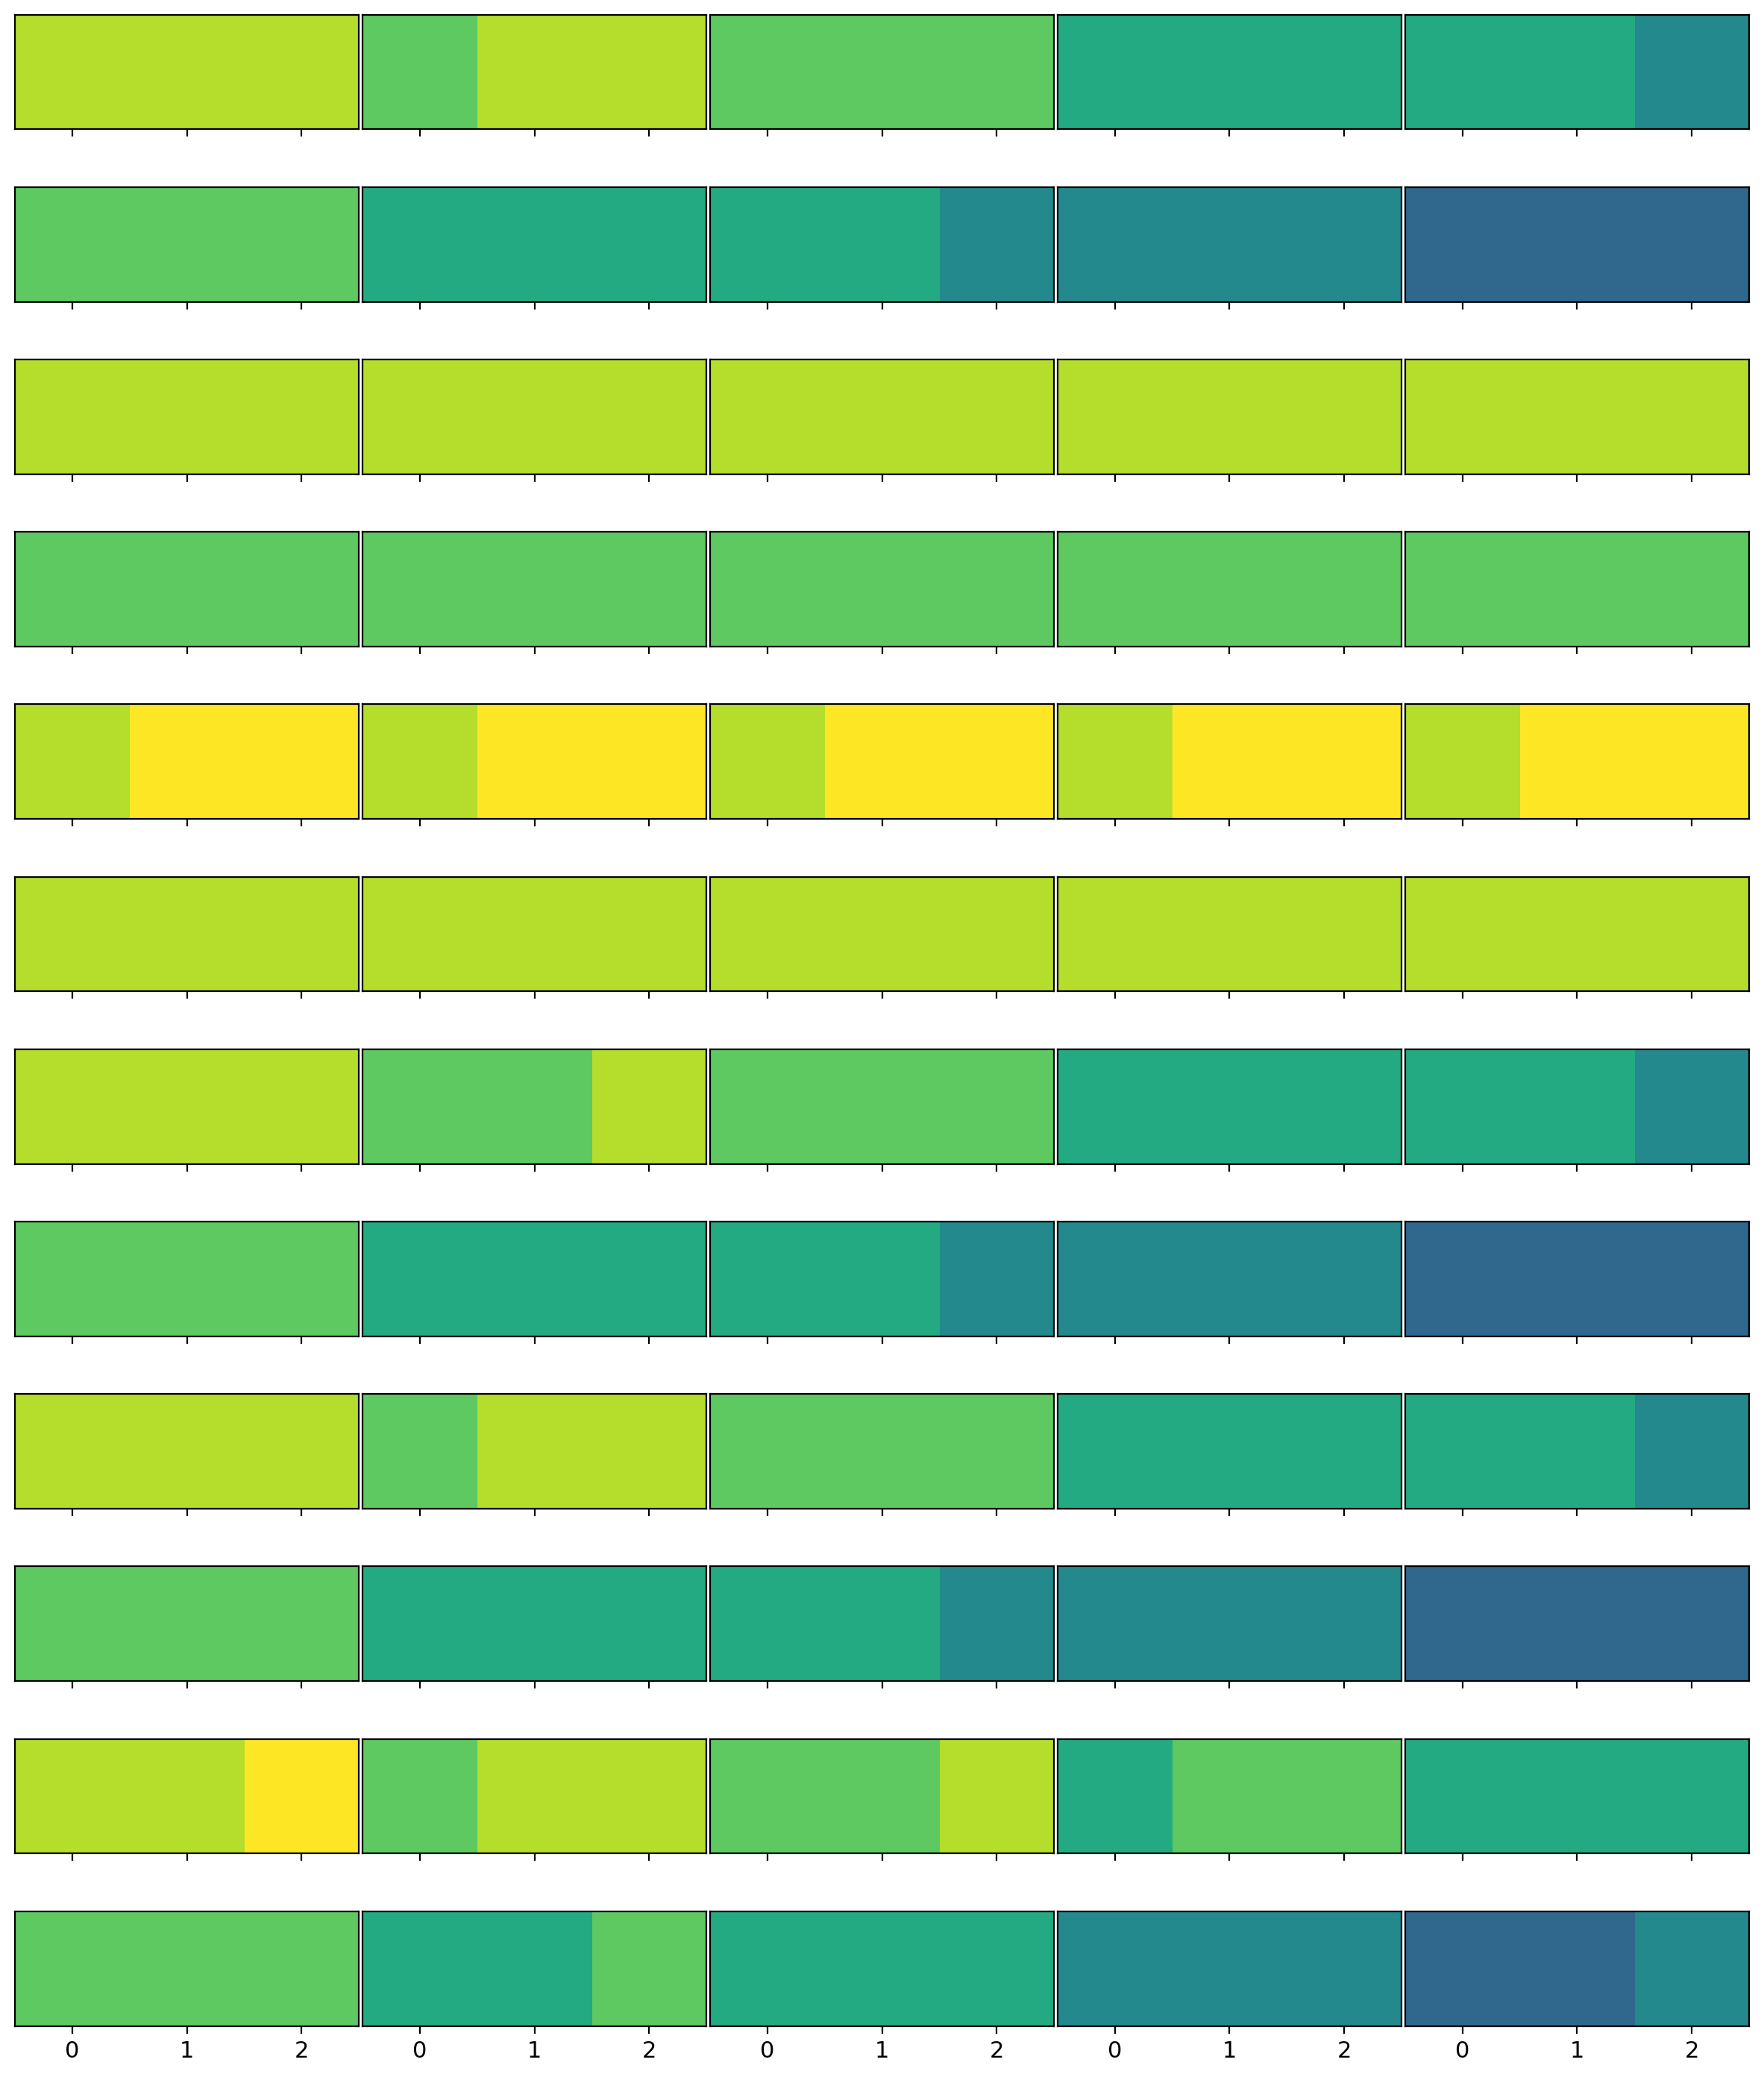

In [8]:
grp0s = list(summaried_df.groupby(["blob_dist_key", "ave_count", "fitting_mode"]))

n_images_count = len(summaried_df["n_images"].unique())
intensities = summaried_df["intensity"].unique()

nrows = len(grp0s)
ncols = n_images_count
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(ncols * 3, nrows * 1.5),
    sharex=True,
    gridspec_kw={"hspace": 0.01, "wspace": 0.01},
)

for row, (image_property, grp0) in enumerate(grp0s):
    grps = list(grp0.groupby("n_images"))
    for col, (n_images, grp) in enumerate(grps):
        ax = axes[row, col]
        df = grp.sort_values("intensity")
        assert np.all(df["intensity"] == intensities)
        # ax.set_xticks(intensities)
        ax.yaxis.set_major_locator(plt.NullLocator())
        ax.imshow(
            [np.log10(df["min_deviation_smoothness_flatfield_median"])], vmin=-2, vmax=1
        )

In [9]:
fourier_l0_norm_thresholds = np.linspace(0, 0.1, 10)
fourier_l0_norm_cost_coefs = [1, 2, 3, 5, 10, 20, 30, 50, 100]

In [10]:
def to_autotune_cost(
    entropy_value, n, fourier_l0_norm_threshold, fourier_l0_norm_cost_coef
):
    if n < fourier_l0_norm_threshold:
        fourier_L0_norm_cost = 0
    else:
        fourier_L0_norm_cost = (
            n - fourier_l0_norm_threshold
        ) * fourier_l0_norm_cost_coef
    return entropy_value + fourier_L0_norm_cost


to_autotune_cost = np.vectorize(to_autotune_cost)

all_ress = []
for fourier_l0_norm_threshold, fourier_l0_norm_cost_coef in tqdm(
    list(product(fourier_l0_norm_thresholds, fourier_l0_norm_cost_coefs))
):
    keys = image_properties + ["fitting_mode", "true_flatfield_id"]
    for vals, grp in estimated_parameters_df.groupby(keys):
        deviation_optimal_diffs = []
        for rep, grp2 in grp.groupby("rep"):
            autotune_cost = to_autotune_cost(
                grp2["entropy"],
                grp2["fourier_L0_norm"],
                fourier_l0_norm_threshold,
                fourier_l0_norm_cost_coef,
            )
            optimal_deviation = grp2["deviation"].min()
            estimated_deviation = grp2["deviation"].values[np.argmin(autotune_cost)]

            r = dict(zip(keys, vals))
            r["fourier_l0_norm_threshold"] = fourier_l0_norm_threshold
            r["fourier_l0_norm_cost_coef"] = fourier_l0_norm_cost_coef
            r["optimal_deviation"] = optimal_deviation
            r["estimated_deviation"] = estimated_deviation
            r["rep"] = rep
            all_ress.append(r)
deviation_df = pd.DataFrame.from_records(all_ress)

100%|██████████| 90/90 [00:44<00:00,  2.01it/s]


In [11]:
deviation_df["deviation_diff"] = (
    deviation_df["estimated_deviation"] - deviation_df["optimal_deviation"]
)
deviation_df2 = (
    deviation_df.groupby(
        keys + ["fourier_l0_norm_threshold", "fourier_l0_norm_cost_coef"]
    )
    .agg(["mean"])
    .reset_index()
)

In [12]:
deviation_df2.head()

n_images blob_dist_key intensity ave_count fitting_mode true_flatfield_id  \
                                                                              
0       10        biased        10         0  approximate                 0   
1       10        biased        10         0  approximate                 0   
2       10        biased        10         0  approximate                 0   
3       10        biased        10         0  approximate                 0   
4       10        biased        10         0  approximate                 0   

  fourier_l0_norm_threshold fourier_l0_norm_cost_coef optimal_deviation  \
                                                                   mean   
0                       0.0                         1          0.005444   
1                       0.0                         2          0.005444   
2                       0.0                         3          0.005444   
3                       0.0                         5          0.005444   
4                       0.0                        10          0.005444   

  estimated_deviation  rep deviation_diff  
                 mean mean           mean  
0            0.007611  2.0       0.002168  
1            0.005444  2.0       0.000000  
2            0.005444  2.0       0.000000  
3            0.005444  2.0       0.000000  
4            0.005444  2.0       0.000000

In [13]:
import warnings

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_21544/1582183793.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_21544/1582183793.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_21544/1582183793.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_21544/1582183793.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


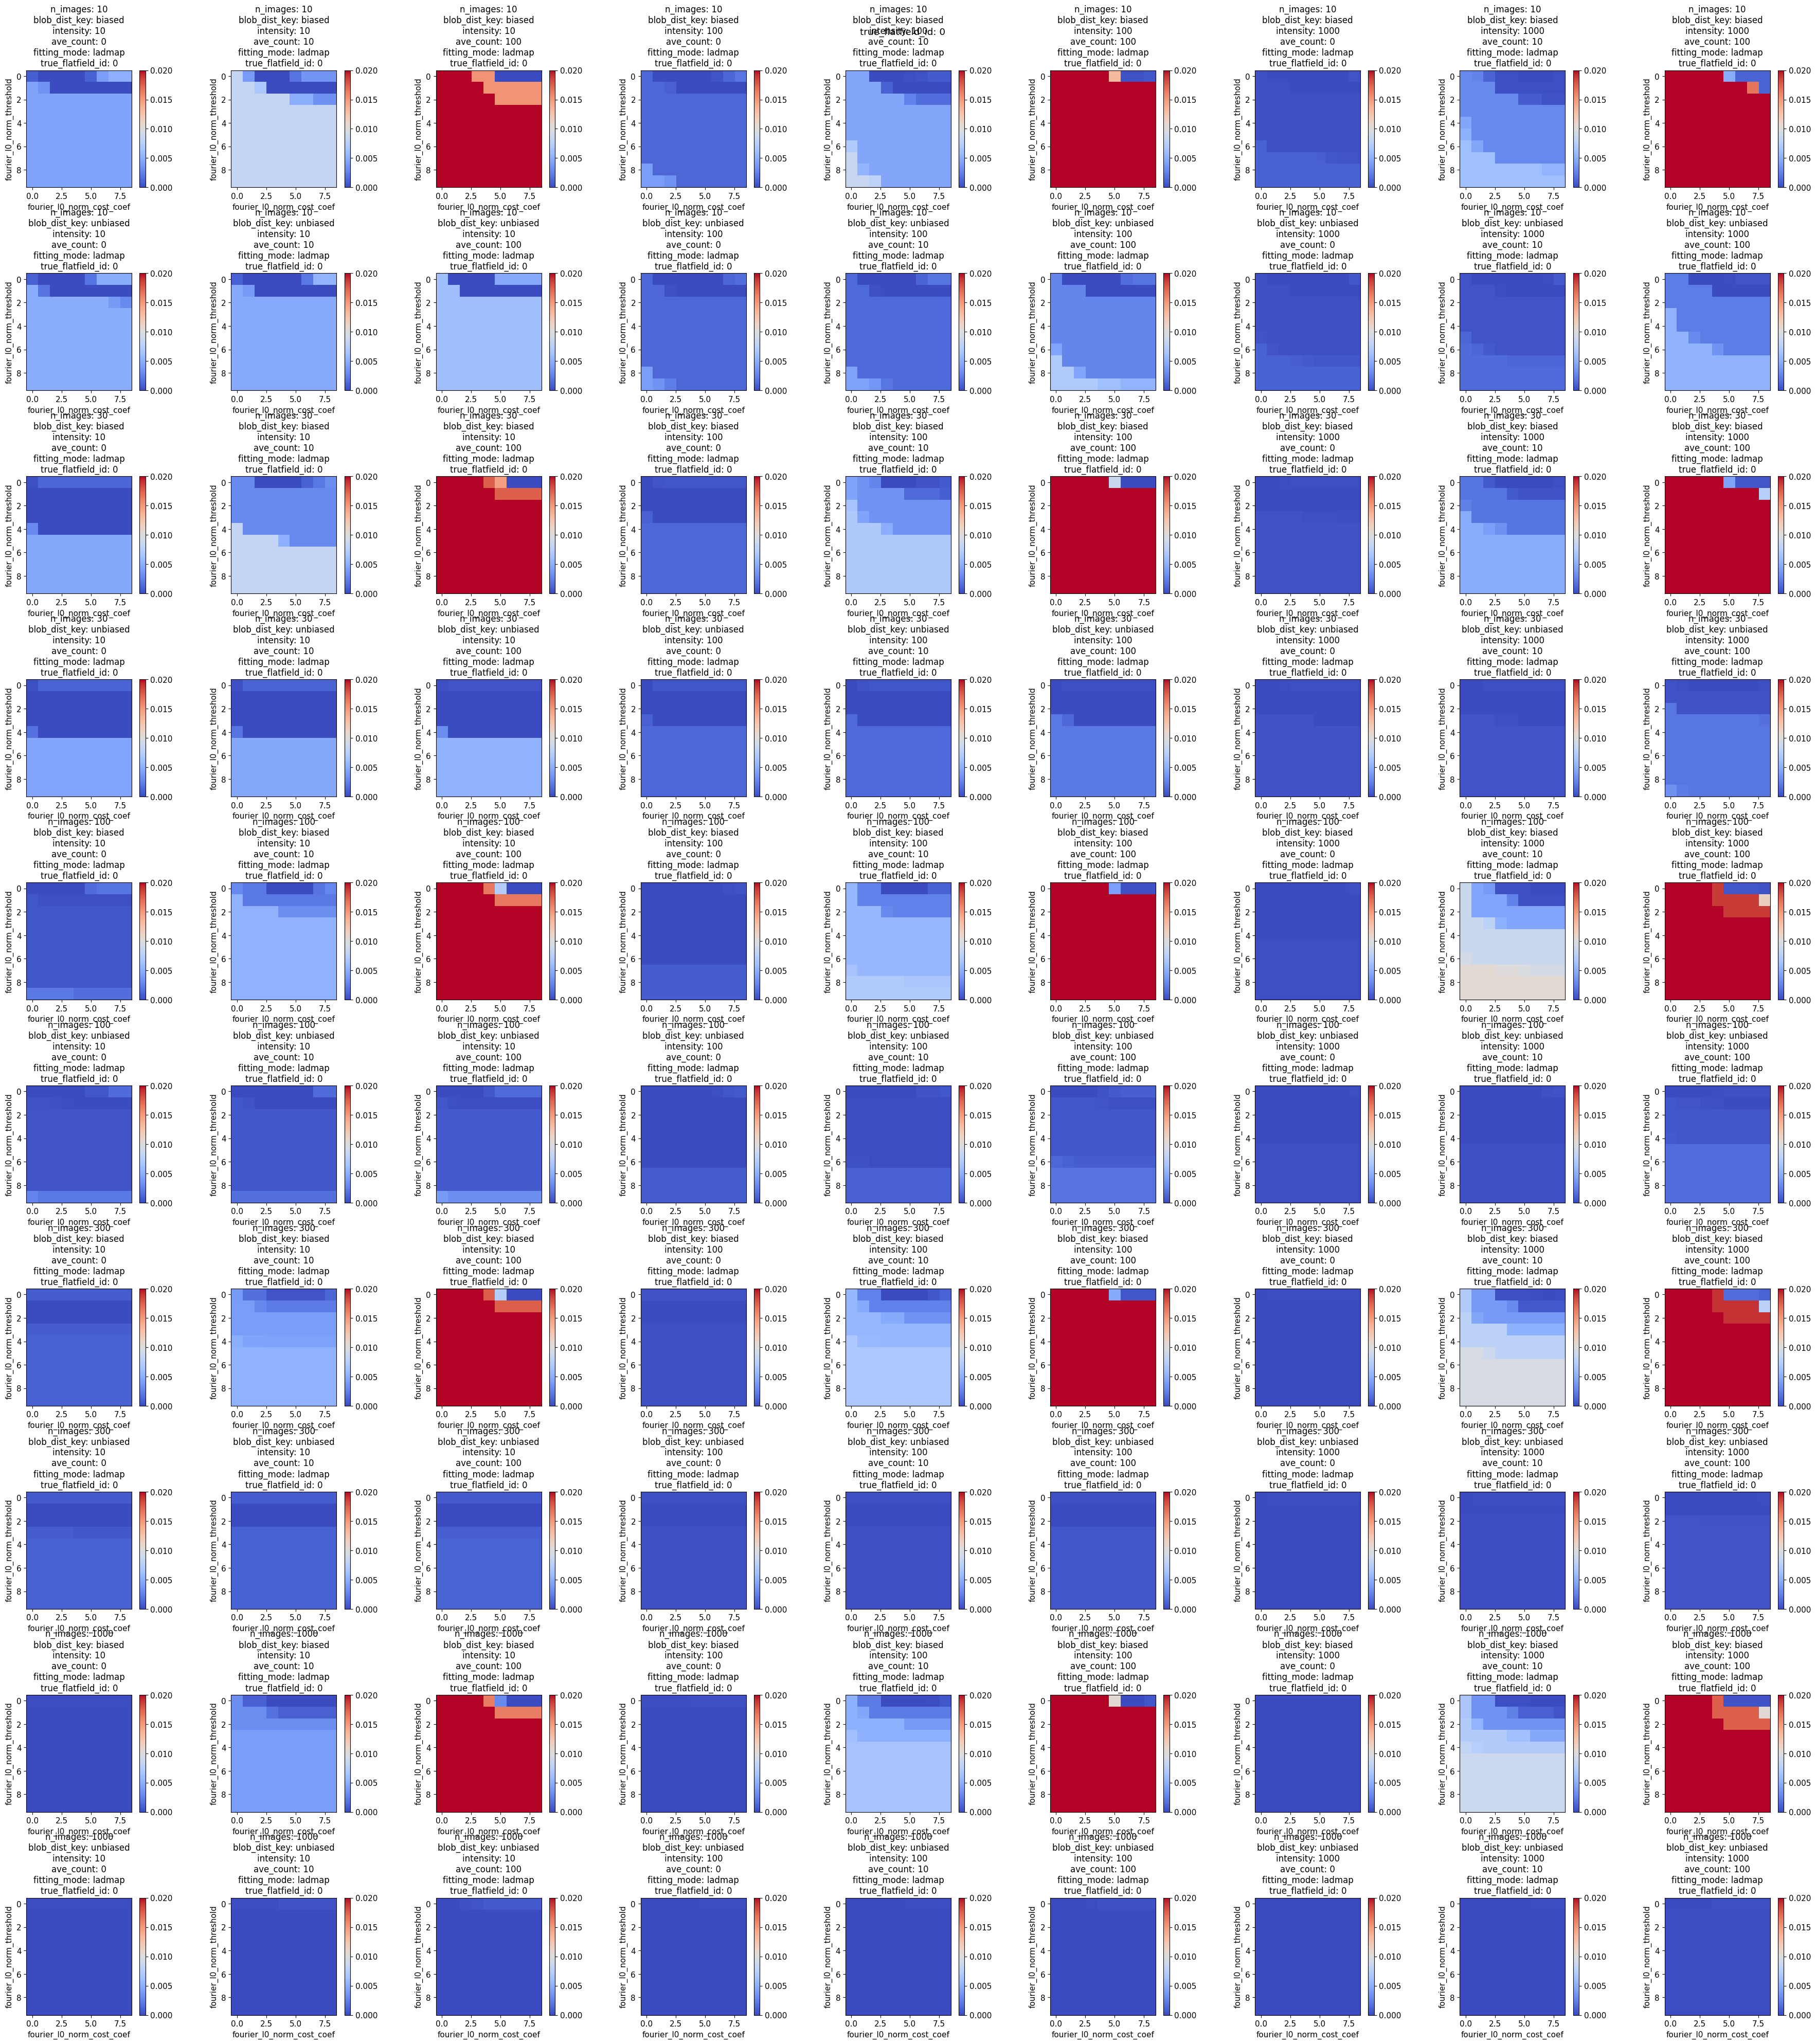

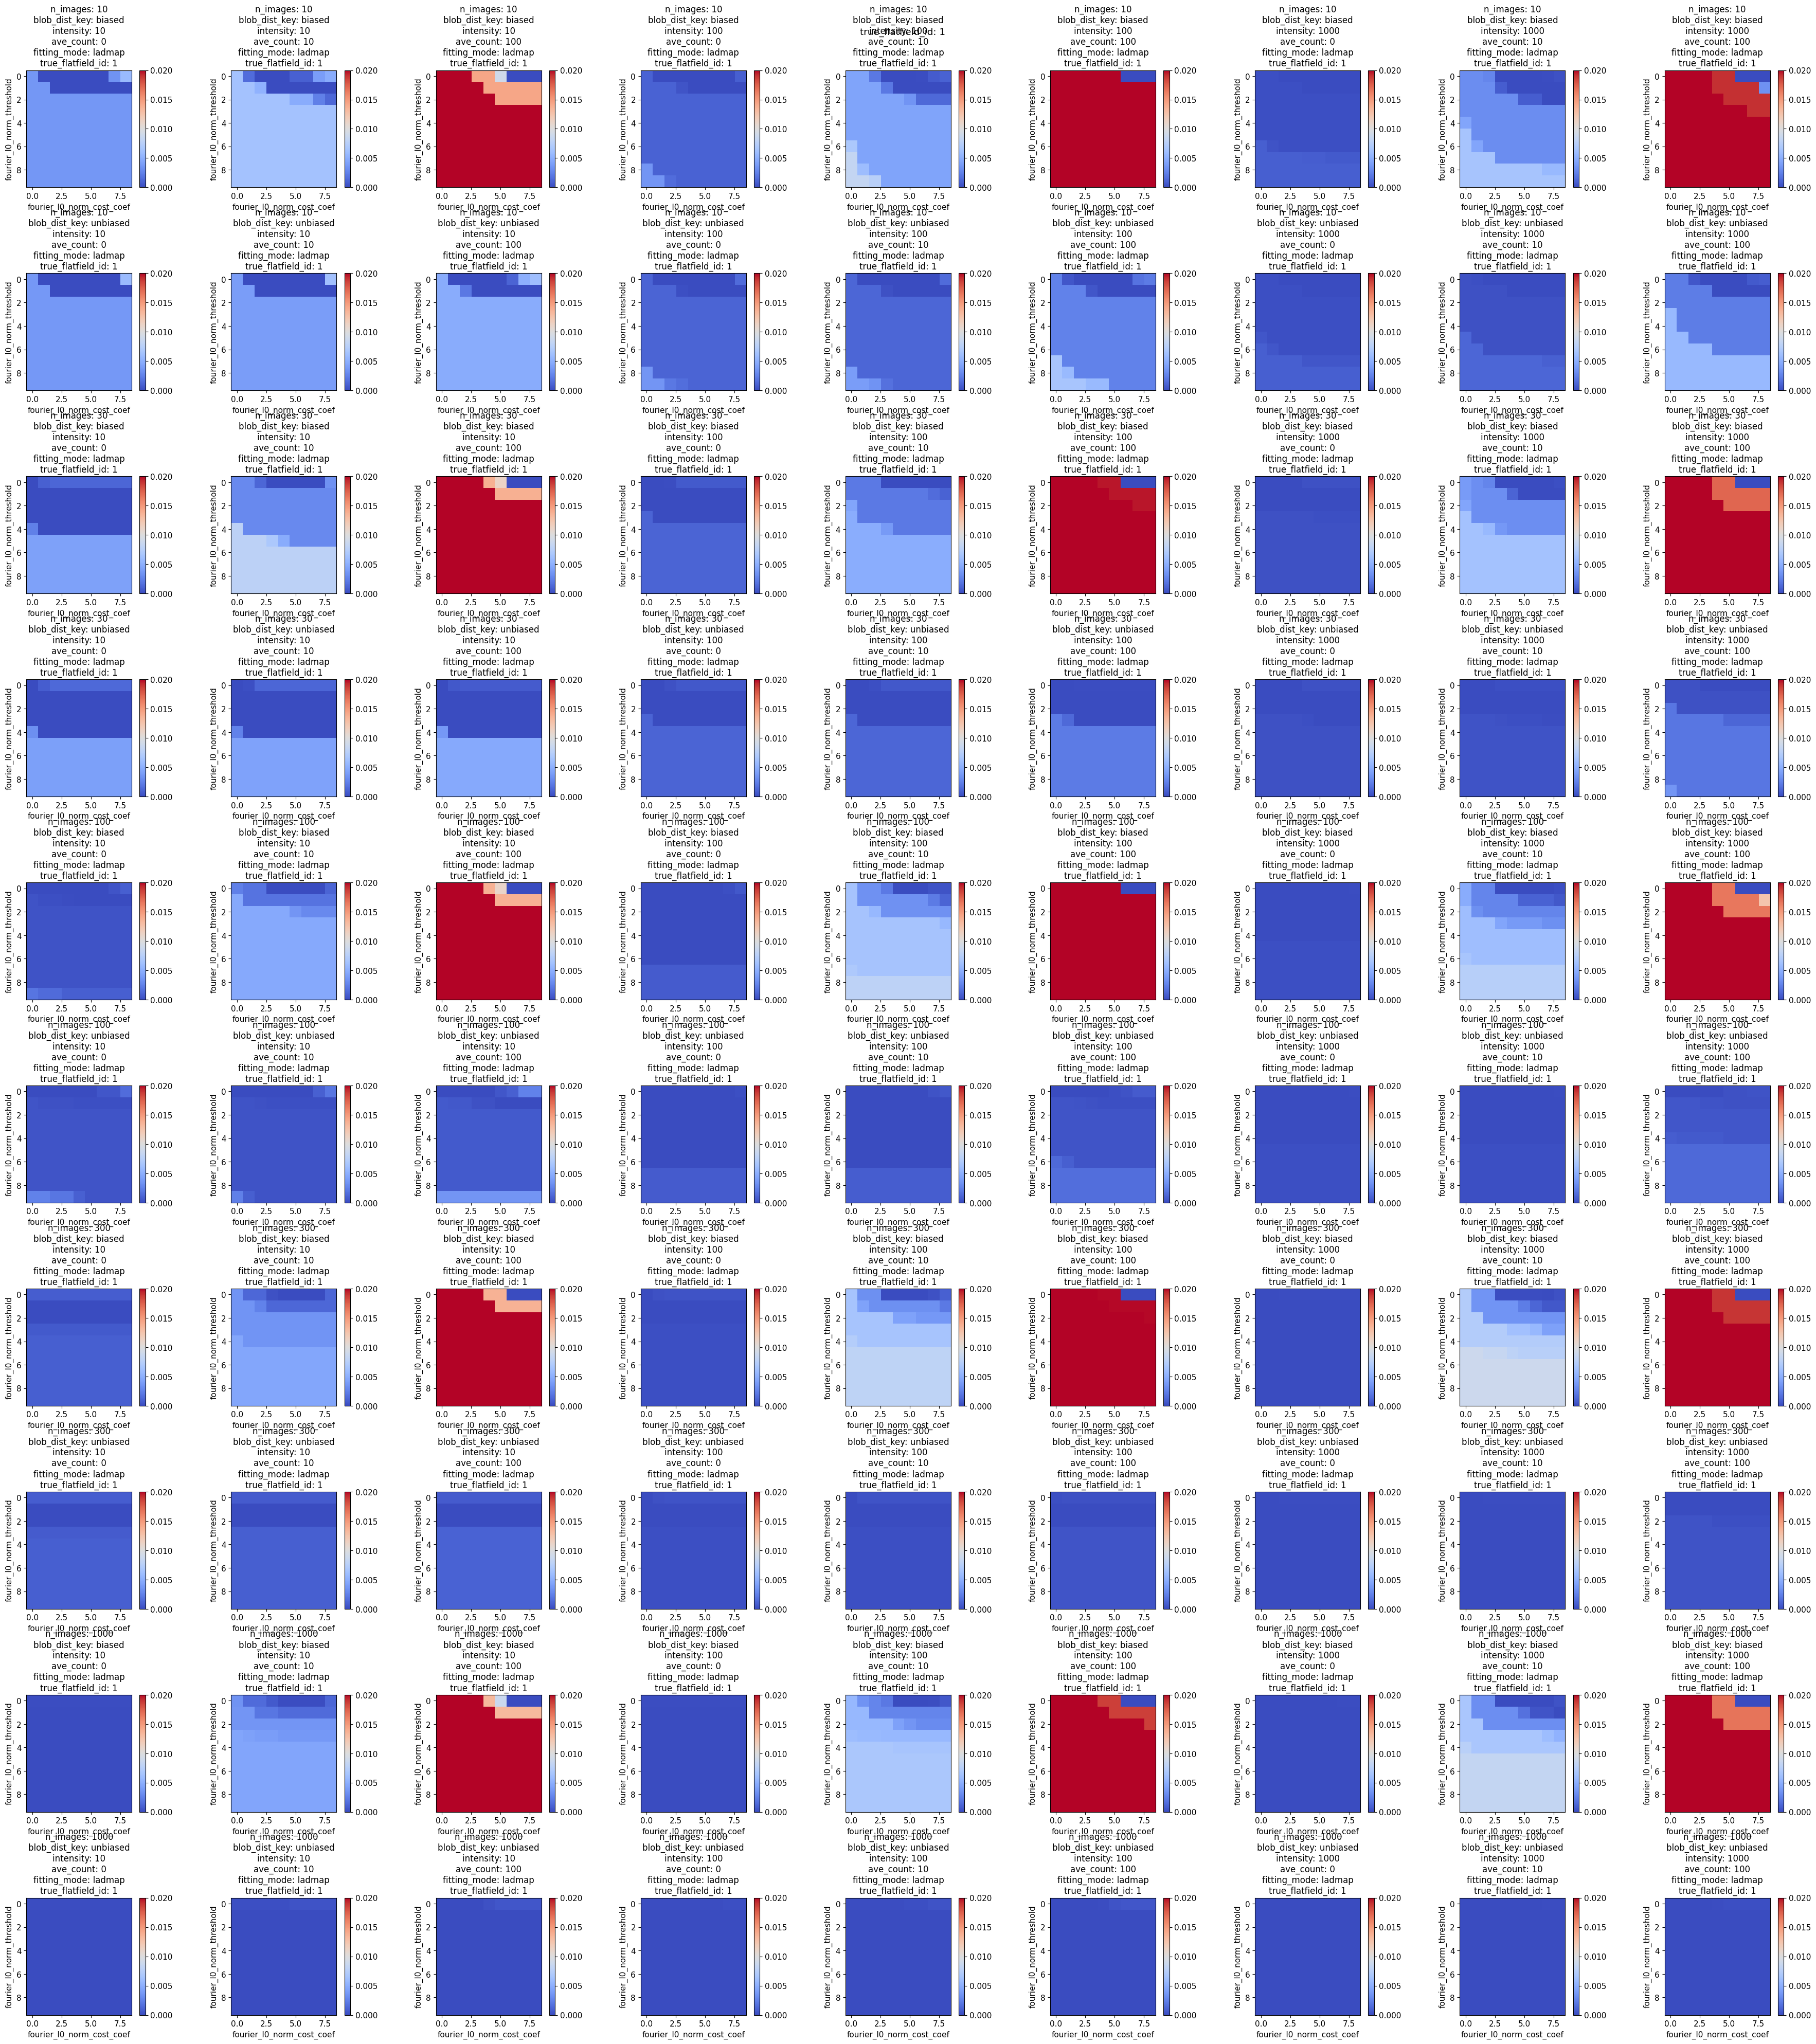

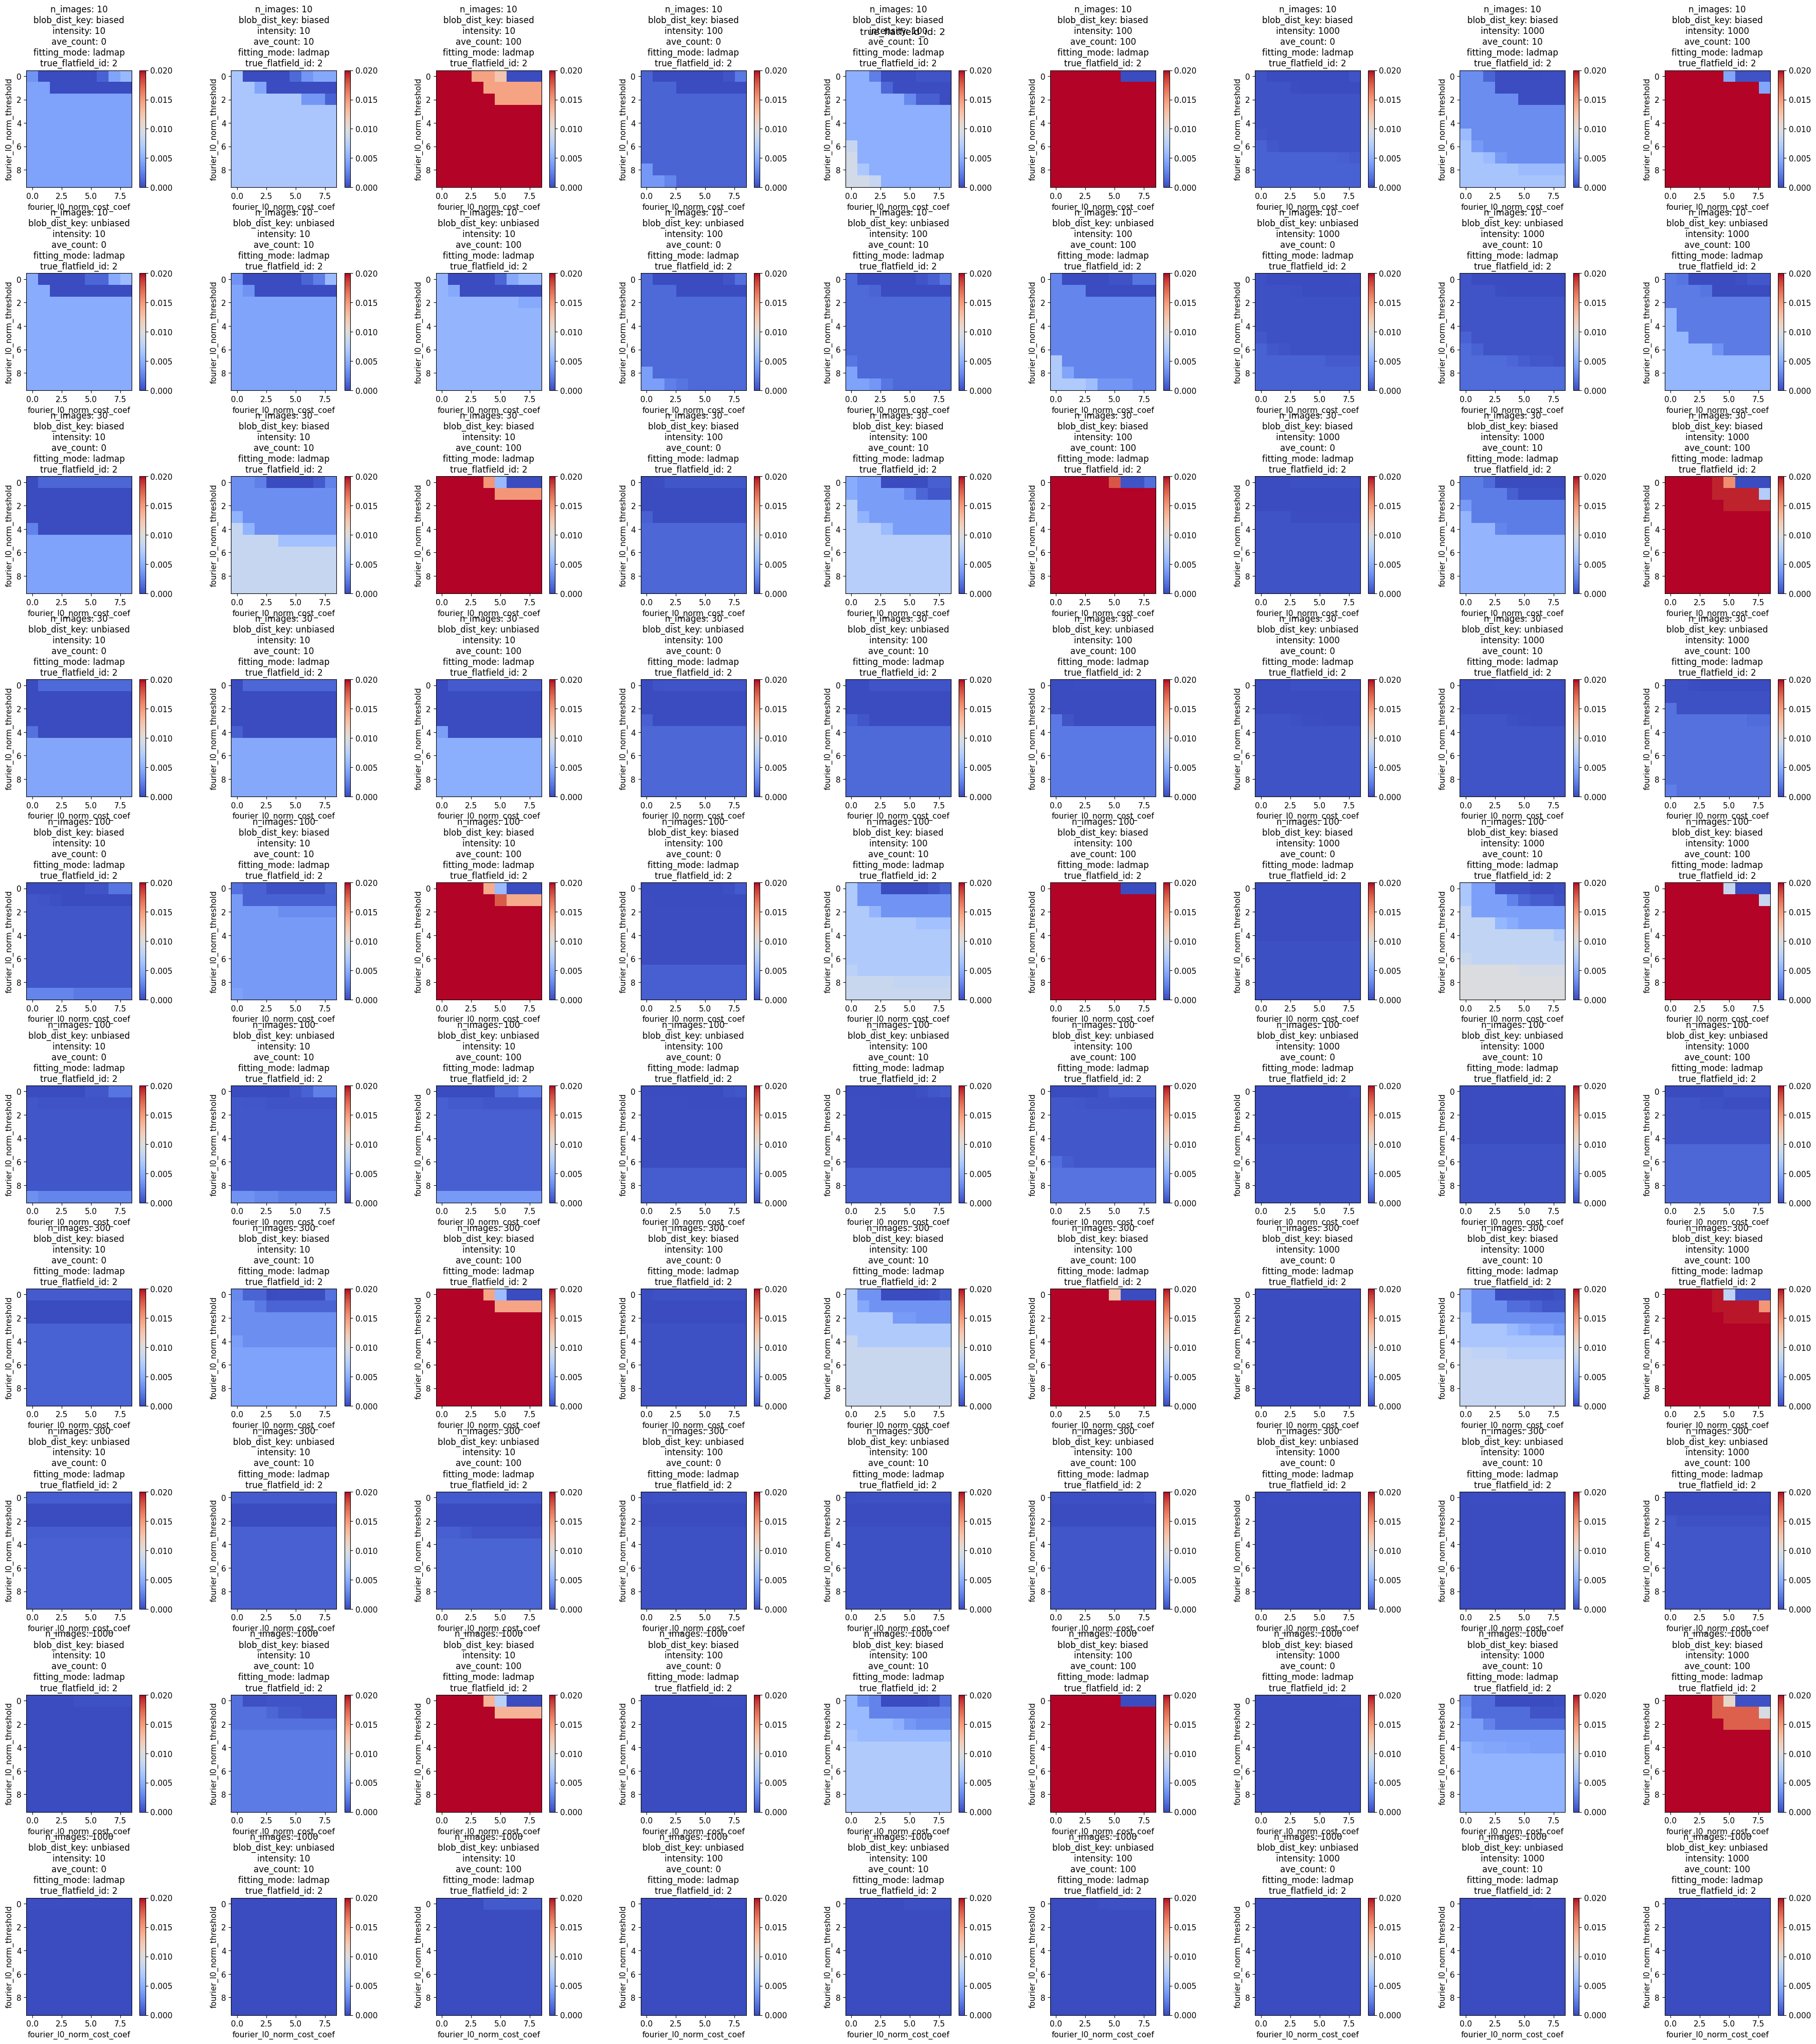

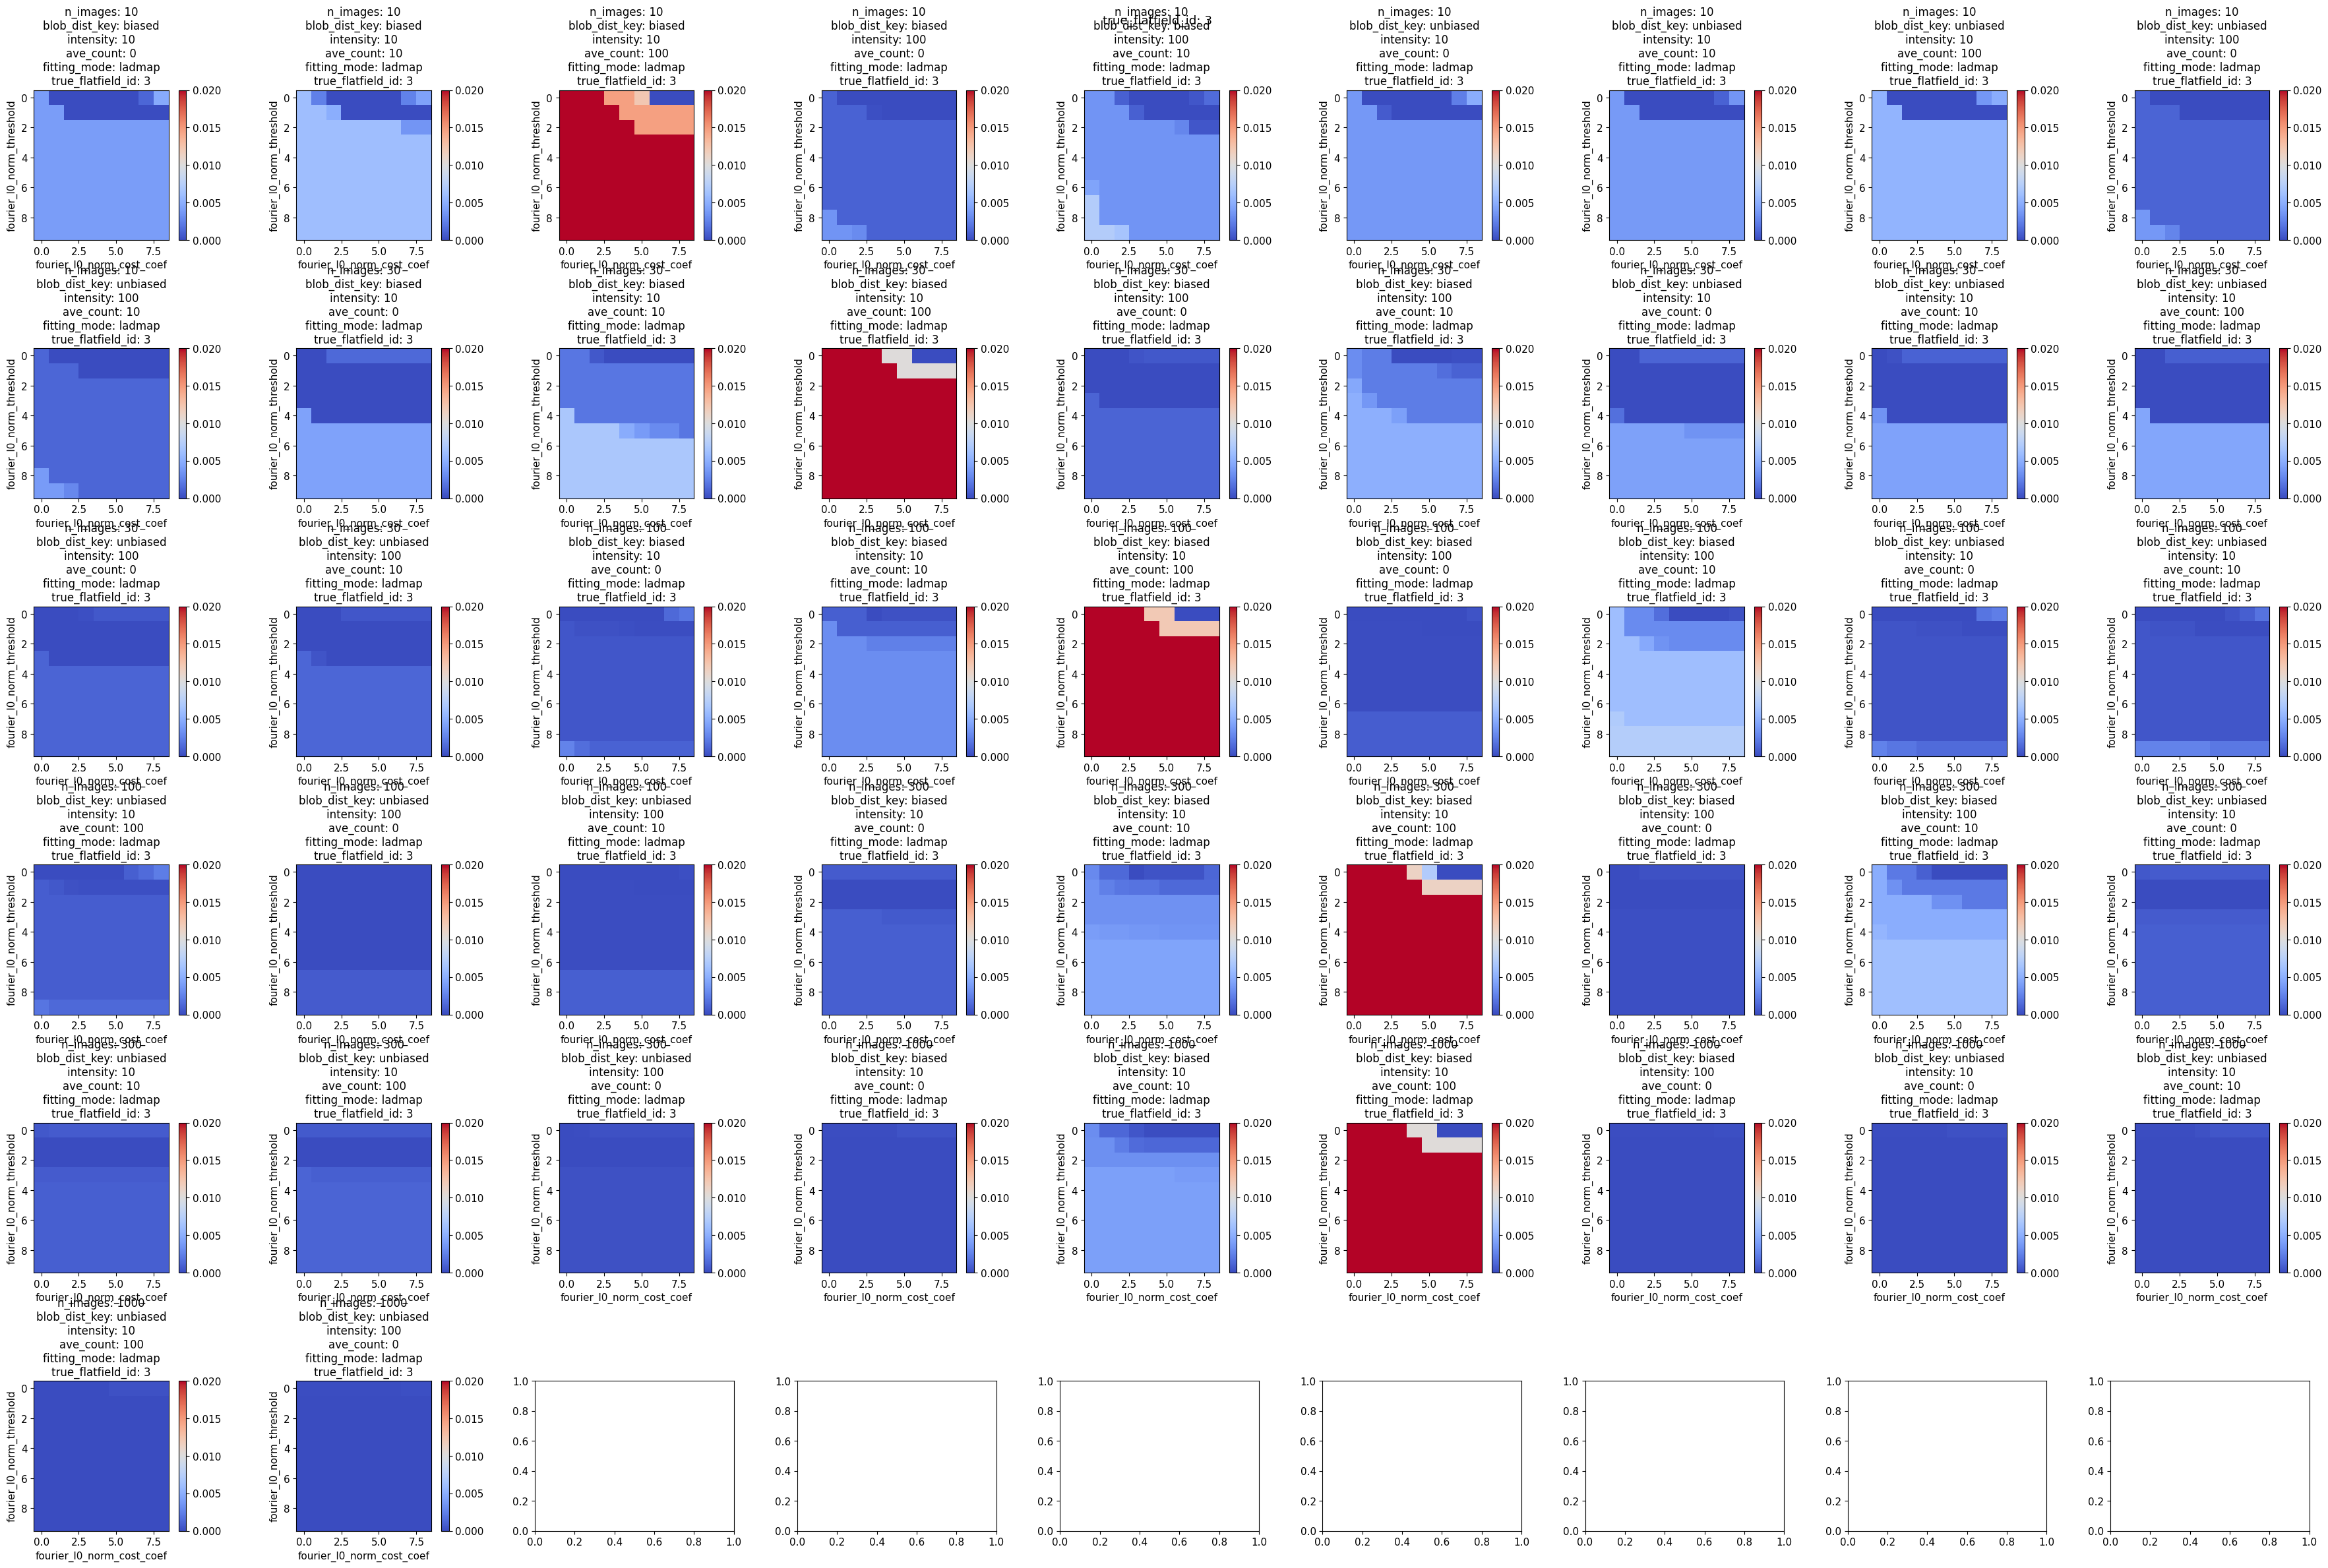

In [14]:
_df = deviation_df2[(deviation_df2["fitting_mode"] == "ladmap")]
for true_flatfield_id, grp0 in _df.groupby("true_flatfield_id"):
    ncols = 9
    nrows = (len(grp0.groupby(keys)) - 1) // ncols + 1
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4 * ncols, 4 * nrows),
        # gridspec_kw={"hspace": 1.5, "wspace": 1.0},
        dpi=50,
    )
    for ax, (vals, grp) in zip(axes.ravel(), grp0.groupby(keys)):
        # Reshape the data
        pivot_df = grp.pivot_table(
            values="deviation_diff",
            index="fourier_l0_norm_threshold",
            columns="fourier_l0_norm_cost_coef",
            fill_value=0,
        )["mean"]

        # Plot the heatmap
        im = ax.imshow(pivot_df, cmap="coolwarm", vmin=0, vmax=0.02)

        # Add colorbar
        cbar = ax.figure.colorbar(im, ax=ax)

        # Set axis labels and title
        ax.set_xlabel("fourier_l0_norm_cost_coef")
        ax.set_ylabel("fourier_l0_norm_threshold")
        ax.set_title("Heatmap of deviation_diff mean values")

        ax.set_title(
            "\n".join([f"{k}: {v}" for k, v in zip(keys, vals)]),
        )
    fig.suptitle(f"true_flatfield_id: {true_flatfield_id}")
    fig.tight_layout()
    fig.show()

In [15]:
fourier_l0_norm_thresholds

array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
       0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ])

In [16]:
fourier_l0_norm_threshold = fourier_l0_norm_thresholds[0]
fourier_l0_norm_cost_coef = sorted(deviation_df2["fourier_l0_norm_cost_coef"].unique())[
    6
]
print(fourier_l0_norm_threshold, fourier_l0_norm_cost_coef)

0.0 30


In [17]:
_df_selected = _df[
    (_df["fourier_l0_norm_threshold"] == fourier_l0_norm_threshold)
    & (_df["fourier_l0_norm_cost_coef"] == fourier_l0_norm_cost_coef)
]
_df_selected

n_images blob_dist_key intensity ave_count fitting_mode  \
                                                                
366         10        biased        10         0       ladmap   
456         10        biased        10         0       ladmap   
546         10        biased        10         0       ladmap   
636         10        biased        10         0       ladmap   
1086        10        biased        10        10       ladmap   
...        ...           ...       ...       ...          ...   
56346     1000      unbiased      1000        10       ladmap   
56436     1000      unbiased      1000        10       ladmap   
56796     1000      unbiased      1000       100       ladmap   
56886     1000      unbiased      1000       100       ladmap   
56976     1000      unbiased      1000       100       ladmap   

      true_flatfield_id fourier_l0_norm_threshold fourier_l0_norm_cost_coef  \
                                                                              
366                   0                       0.0                        30   
456                   1                       0.0                        30   
546                   2                       0.0                        30   
636                   3                       0.0                        30   
1086                  0                       0.0                        30   
...                 ...                       ...                       ...   
56346                 1                       0.0                        30   
56436                 2                       0.0                        30   
56796                 0                       0.0                        30   
56886                 1                       0.0                        30   
56976                 2                       0.0                        30   

      optimal_deviation estimated_deviation  rep deviation_diff  
                   mean                mean mean           mean  
366            0.005130            0.009072  2.0       0.003943  
456            0.006408            0.006408  2.0       0.000000  
546            0.005337            0.006422  2.0       0.001085  
636            0.005792            0.005792  2.0       0.000000  
1086           0.006252            0.009798  2.0       0.003547  
...                 ...                 ...  ...            ...  
56346          0.000454            0.000498  2.0       0.000044  
56436          0.000168            0.000282  2.0       0.000114  
56796          0.000273            0.000429  2.0       0.000157  
56886          0.000528            0.000690  2.0       0.000163  
56976          0.000268            0.000418  2.0       0.000150  

[317 rows x 12 columns]

array([[<Axes: title={'center': 'mean'}>]], dtype=object)

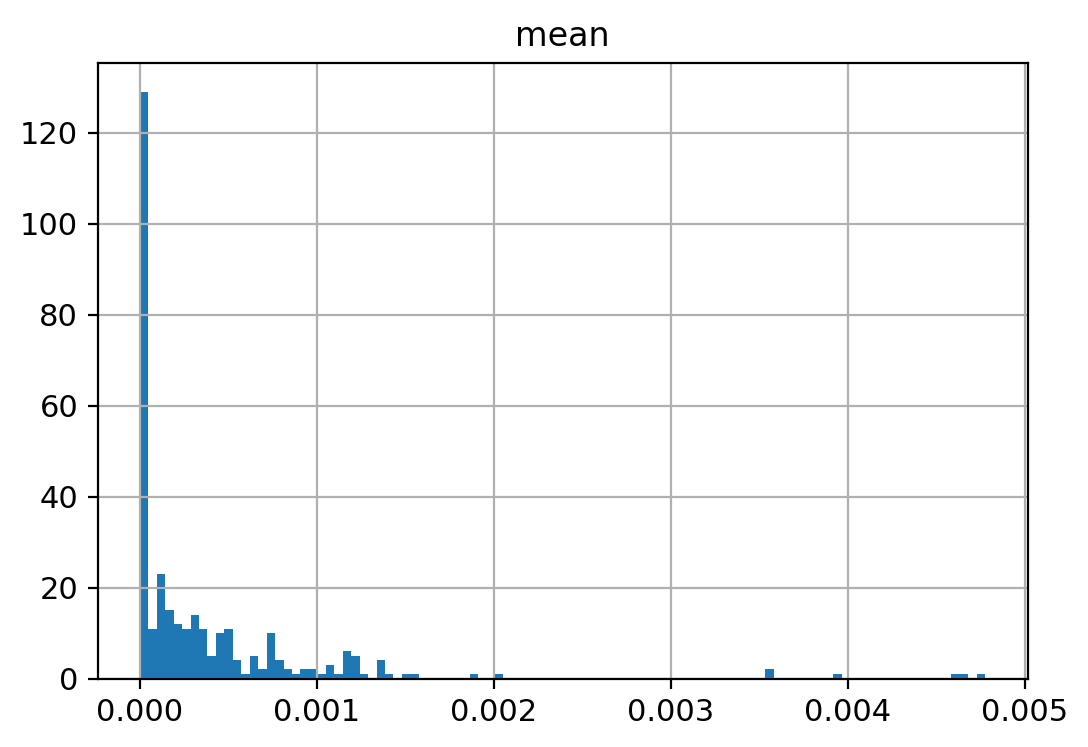

In [18]:
_df_selected["deviation_diff"].hist(bins=100)